### **загрузка датасета**

In [1]:
import zipfile
import pandas as pd

In [2]:
# путь к архиву
zip_path = 'archive.zip'
csv_filename = 'SBAnational.csv'

In [3]:
# разархивируем файл
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
# загружаем CSV-файл в DataFrame
df = pd.read_csv(csv_filename)

<ipython-input-4-24c63ac5282a>:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_filename)


In [5]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur



---



### **предобработка датасета**

In [6]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [7]:
print("пропуски в данных до обработки:")
print(df.isnull().sum())

пропуски в данных до обработки:
LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64


In [8]:
# заполнение пропусков
# для числовых данных заменяем пропуски на медиану
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# для категориальных данных заменяем пропуски на 'Unknown'
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna('Unknown')

In [9]:
print("пропуски в данных после обработки:")
print(df.isnull().sum())

пропуски в данных после обработки:
LoanNr_ChkDgt        0
Name                 0
City                 0
State                0
Zip                  0
Bank                 0
BankState            0
NAICS                0
ApprovalDate         0
ApprovalFY           0
Term                 0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr            0
LowDoc               0
ChgOffDate           0
DisbursementDate     0
DisbursementGross    0
BalanceGross         0
MIS_Status           0
ChgOffPrinGr         0
GrAppv               0
SBA_Appv             0
dtype: int64


In [10]:
# удаление выбросов с использованием метода межквартильного размаха (IQR)
def remove_outliers(data, columns):
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

df = remove_outliers(df, num_cols)

In [11]:
# приведение всех категориальных данных к строковому типу
for col in cat_cols:
    df[col] = df[col].astype(str)

In [12]:
# кодирование категориальных переменных
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [13]:
# нормализация числовых данных
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [14]:
# вывод информации о предобработанном наборе данных
print("информация о данных после предобработки:")
print(df.info())
print(df.head())

информация о данных после предобработки:
<class 'pandas.core.frame.DataFrame'>
Index: 378519 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      378519 non-null  float64
 1   Name               378519 non-null  int64  
 2   City               378519 non-null  int64  
 3   State              378519 non-null  int64  
 4   Zip                378519 non-null  float64
 5   Bank               378519 non-null  int64  
 6   BankState          378519 non-null  int64  
 7   NAICS              378519 non-null  float64
 8   ApprovalDate       378519 non-null  int64  
 9   ApprovalFY         378519 non-null  int64  
 10  Term               378519 non-null  float64
 11  NoEmp              378519 non-null  float64
 12  NewExist           378519 non-null  float64
 13  CreateJob          378519 non-null  float64
 14  RetainedJob        378519 non-null  float64
 15  FranchiseCode  



---



### **разделение на обучающую и тестовую выборки**

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
# разделение данных на признаки и целевую переменную
X = df.drop(['MIS_Status'], axis=1)  # исключаем целевую переменную
y = df['MIS_Status']  # целевая переменная

# разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



---



### **построение моделей**

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [18]:
# 1. Классическая модель: Случайный лес
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print("случайный лес:")
print(classification_report(y_test, y_pred_rf))

случайный лес:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     10820
           1       1.00      0.99      1.00     64693
           2       0.97      0.55      0.70       191

    accuracy                           0.99     75704
   macro avg       0.98      0.85      0.89     75704
weighted avg       0.99      0.99      0.99     75704



In [19]:
# 2. Модель на основе искусственных нейронных сетей
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# оценка нейронной сети
y_pred_ann = model.predict(X_test).round()
print("нейронная сеть:")
print(classification_report(y_test, y_pred_ann))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
7571/7571 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9514 - loss: 220.5161 - val_accuracy: 0.9904 - val_loss: 10.4432
Epoch 2/10
7571/7571 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9832 - loss: 3.4700 - val_accuracy: 0.9778 - val_loss: -79.9250
Epoch 3/10
7571/7571 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9844 - loss: -213.3832 - val_accuracy: 0.9845 - val_loss: -1311.6621
Epoch 4/10
7571/7571 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.9850 - loss: -1983.9398 - val_accuracy: 0.9894 - val_loss: -7031.4136
Epoch 5/10
7571/7571 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9850 - loss: -9650.3193 - val_accuracy: 0.8963 - val_loss: -20481.7090
Epoch 6/10
7571/7571 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.9846 - loss: -25044.2969 - val_accuracy: 0.9908 - val_loss: -45040.8633
Epoch 7/10
7571/7571 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9851 - loss: -54933.0391 - val_accuracy: 0.9904 - val_loss: -86150.3281
Epoch 8/10
7571/7571 ━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
# 3. Кластеризация для сегментации граждан
# стандартизация данных перед кластеризацией
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# применение KMeans для кластеризации
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# добавление информации о кластерах в DataFrame
df['Cluster'] = clusters

In [21]:
# проверка распределения данных по кластерам
cluster_counts = df['Cluster'].value_counts()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


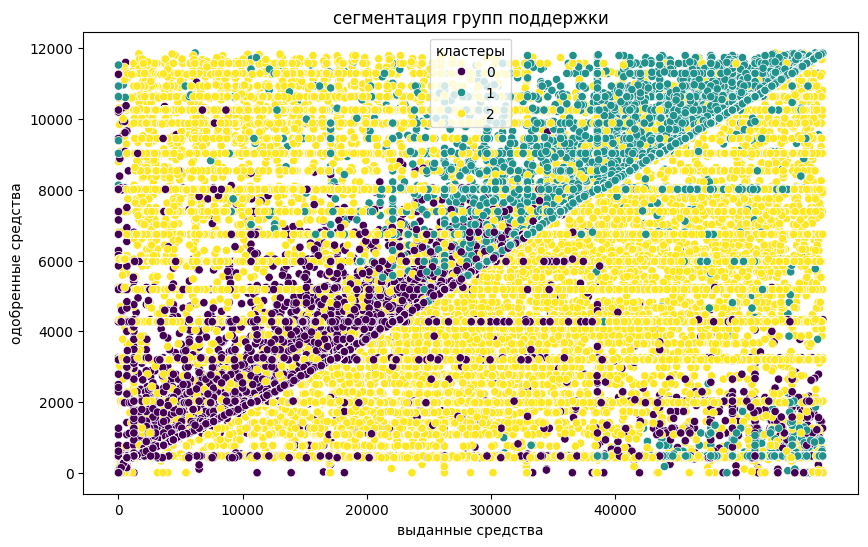

In [22]:
# визуализация кластеров на основе двух ключевых признаков
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df['DisbursementGross'], y=df['GrAppv'], hue=df['Cluster'], palette='viridis'
)
plt.title('сегментация групп поддержки')
plt.xlabel('выданные средства')
plt.ylabel('одобренные средства')
plt.legend(title='кластеры')
plt.show()

<ipython-input-23-a23924040eff>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


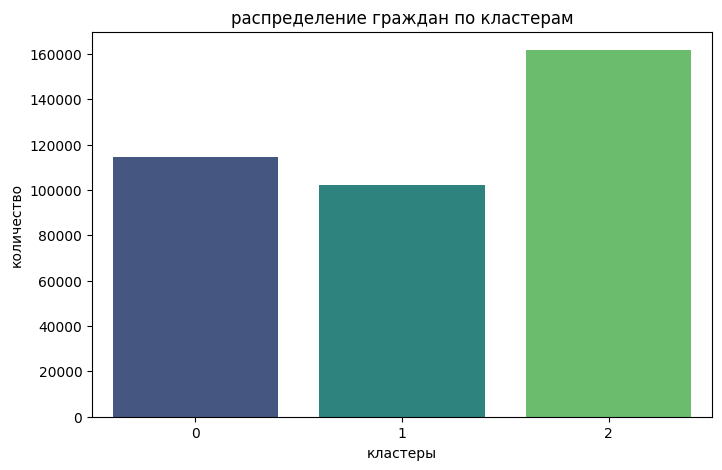

In [23]:
# визуализация распределения граждан по кластерам
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.title('распределение граждан по кластерам')
plt.xlabel('кластеры')
plt.ylabel('количество')
plt.show()

In [24]:
# прогнозирование нуждаемости
X_new = X_test.copy()
X_new['Prediction_RF'] = rf_clf.predict(X_test)
X_new['Prediction_ANN'] = y_pred_ann
print(X_new.head())

        LoanNr_ChkDgt    Name   City  State       Zip  Bank  BankState  \
723349       0.811122  330476  19706     38 -1.038598   981         42   
297529      -0.885278  237762  12603      9 -0.548793  4129         37   
809281       1.245112   84841  16043     44  1.037331  2944         47   
679465       0.609360   98078   3284      8 -1.020733   981         42   
604826       0.232136   32776  13541      4  1.311867  4301          4   

           NAICS  ApprovalDate  ApprovalFY  ...  LowDoc  ChgOffDate  \
723349 -0.512436          1232          15  ...       3        4768   
297529 -1.409696          4928          10  ...       3        4768   
809281  0.627551          4106          16  ...       3        4768   
679465 -0.151378          4047          15  ...       3        4768   
604826 -1.409696          1126           5  ...       3        4768   

        DisbursementDate  DisbursementGross  BalanceGross  ChgOffPrinGr  \
723349              2700              11600          

### **анализ**

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Сравнение моделей:
     Метрика  Случайный лес  Нейронная сеть
0  Precision       0.993544        0.986681
1     Recall       0.993369        0.989129
2   F1-score       0.993252        0.987898
3   Accuracy       0.993369        0.989129


<Figure size 1000x600 with 0 Axes>

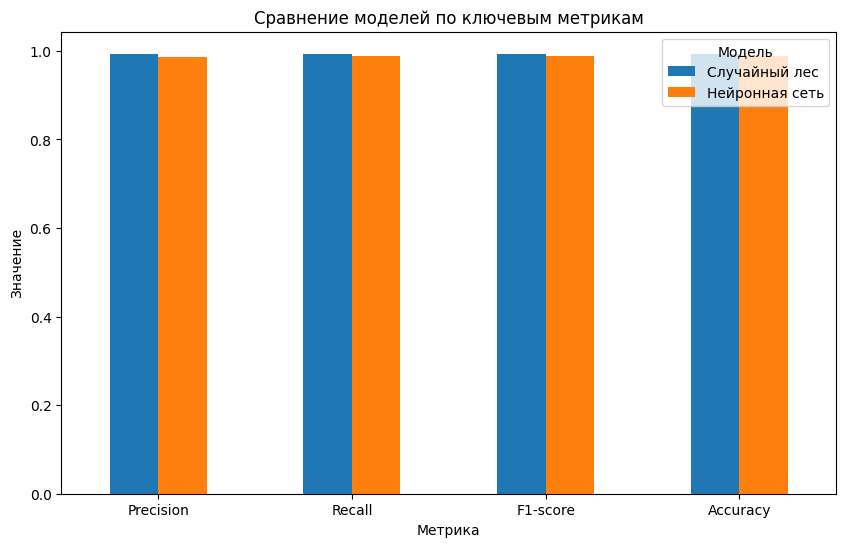

In [27]:
# 1. Сравнение моделей по точности и производительности
# расчет метрик для случайного леса
rf_precision = precision_score(y_test, y_pred_rf, average='weighted')
rf_recall = recall_score(y_test, y_pred_rf, average='weighted')
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')
rf_accuracy = accuracy_score(y_test, y_pred_rf)

# расчет метрик для нейронной сети
ann_precision = precision_score(y_test, y_pred_ann, average='weighted')
ann_recall = recall_score(y_test, y_pred_ann, average='weighted')
ann_f1 = f1_score(y_test, y_pred_ann, average='weighted')
ann_accuracy = accuracy_score(y_test, y_pred_ann)

# создание таблицы сравнения
comparison_df = pd.DataFrame({
    "Метрика": ["Precision", "Recall", "F1-score", "Accuracy"],
    "Случайный лес": [rf_precision, rf_recall, rf_f1, rf_accuracy],
    "Нейронная сеть": [ann_precision, ann_recall, ann_f1, ann_accuracy]
})
print("Сравнение моделей:")
print(comparison_df)

# визуализация сравнения моделей
plt.figure(figsize=(10, 6))
comparison_df.set_index("Метрика").plot(kind="bar", figsize=(10, 6), rot=0)
plt.title("Сравнение моделей по ключевым метрикам")
plt.ylabel("Значение")
plt.legend(title="Модель")
plt.show()

Анализ кластеров:
   Кластер  Средний объем выдачи  Медианный объем выдачи  \
0        0          14180.703530                 12789.0   
1        1          42997.265517                 43624.0   
2        2          25397.205770                 26182.5   

   Средний объем одобрения  Медианный объем одобрения  \
0              2765.400028                     2347.0   
1              8864.134305                     9030.0   
2              4849.719695                     4467.0   

   Среднее число сотрудников  
0                   0.402130  
1                   0.075301  
2                  -0.332604  


<ipython-input-28-59fec9af0f57>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=df, palette='viridis')


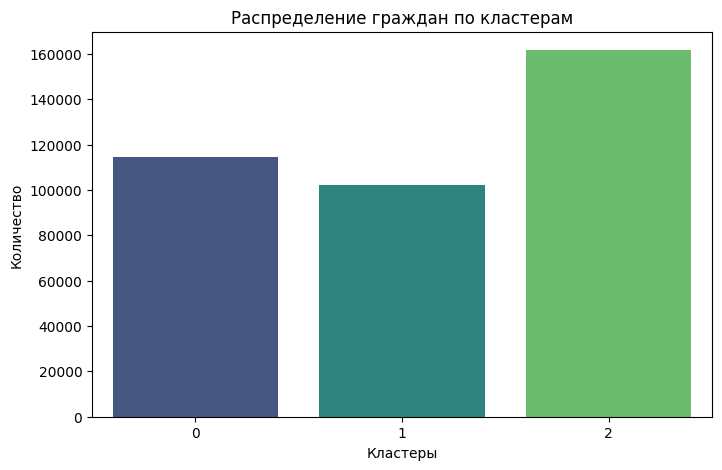

<ipython-input-28-59fec9af0f57>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='DisbursementGross', data=df, palette='viridis')


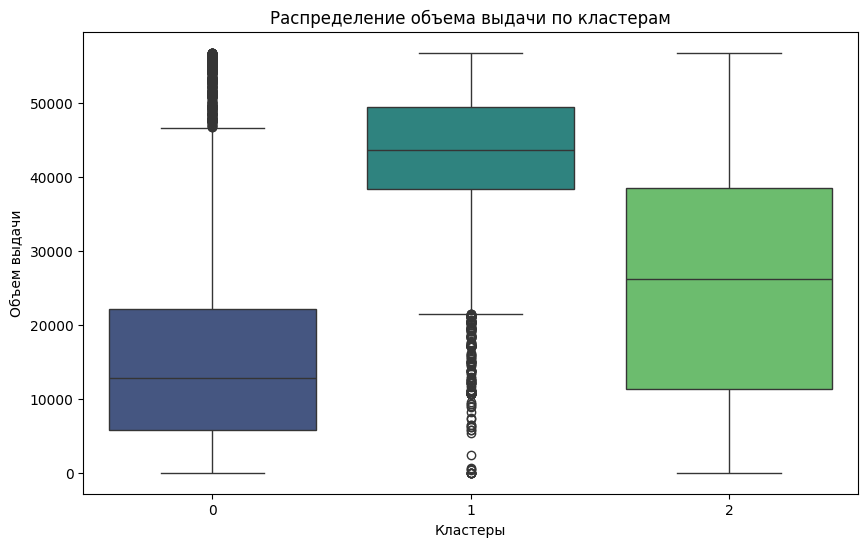

In [28]:
# 2. Анализ полученных кластеров (сегментов)
print("Анализ кластеров:")
cluster_analysis = df.groupby('Cluster').agg({
    'DisbursementGross': ['mean', 'median'],
    'GrAppv': ['mean', 'median'],
    'NoEmp': 'mean'
}).reset_index()
cluster_analysis.columns = ['Кластер', 'Средний объем выдачи', 'Медианный объем выдачи',
                            'Средний объем одобрения', 'Медианный объем одобрения',
                            'Среднее число сотрудников']
print(cluster_analysis)

# визуализация распределения кластеров
plt.figure(figsize=(8, 5))
sns.countplot(x='Cluster', data=df, palette='viridis')
plt.title('Распределение граждан по кластерам')
plt.xlabel('Кластеры')
plt.ylabel('Количество')
plt.show()

# визуализация характеристик кластеров
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='DisbursementGross', data=df, palette='viridis')
plt.title('Распределение объема выдачи по кластерам')
plt.xlabel('Кластеры')
plt.ylabel('Объем выдачи')
plt.show()